## Image Color Mapping and Finding the Eye
This is a notebook that shows off what is actually done in C++ using GPU.

### Auxilary function to display images

In [1]:
%matplotlib inline

from matplotlib import pyplot as plt
from os import path
import numpy as np
import cv2
import pandas as pd

def show_images(images,titles=None, scale=1.3):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        if image.ndim == 2: # Is image grayscale?
            plt.imshow(image)
        else:
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
        a.set_title(title)
        plt.axis("off")
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * n_ims / scale)
    plt.show()
    

### Image Preprocessing

1. Downsample with Gaussian Pyramid
2. Find the eye.
  1. Canny edge finder
  2. Find contours
  3. Find the joining convex hull
  4. Create a mask for this hull. The mask is resized to the final image size
3. Apply [Histogram Specification](http://fourier.eng.hmc.edu/e161/lectures/contrast_transform/node3.html) to normalize color maps
  1. Compute CDF of the reference image
  2. Compute CDF of the input image
  3. Create a mapping from refrence to image CDF
  4. Realize mapping
4. Apply CLAHE on the V channel of the image, converted to HSV.
5. Resize to 256x256
6. Apply the mask (above) to clean up the background

The images supplied vary drastically in their palettes. To simplify feature extraction we need to first normalize them to the same color. 

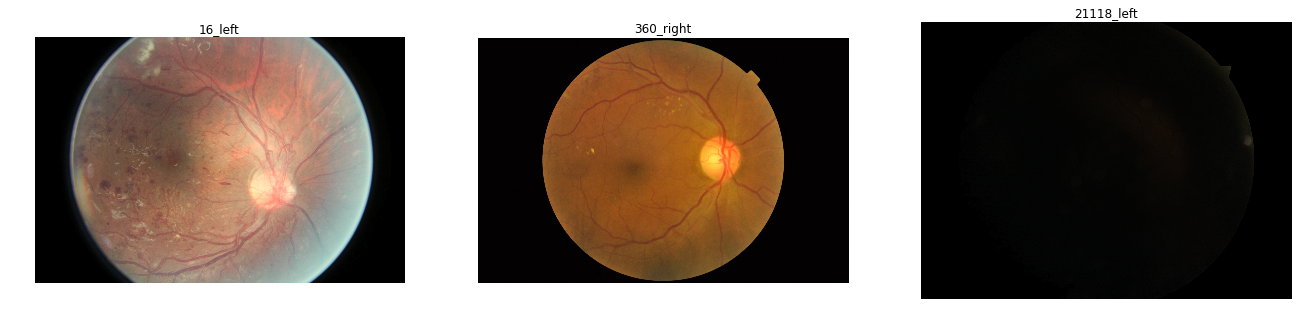

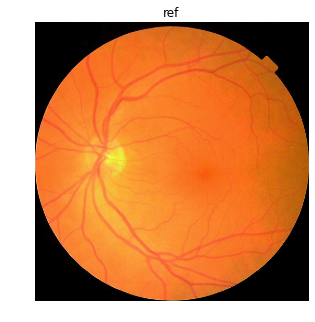

In [13]:
img_path = "/kaggle/retina/train/sample"
# this is the image into the colors of which we want to map
ref_image = cv2.imread(path.join(img_path, "6535_left.jpeg"))
# images picked to illustrate different problems arising during algorithm application
image_names = ["16_left.jpeg", "360_right.jpeg", "21118_left.jpeg"]
image_paths = map(lambda t: path.join(img_path, t), image_names)
images = map(lambda p: cv2.imread(p), image_paths)

# let's see what we've got
image_titles = map(lambda i: path.splitext(i)[0], image_names)
show_images(images, image_titles, scale = 0.8)

show_images([ref_image], ["ref"], scale = 0.8)

##Prepare: PyrDown & Blurr

In [14]:
#Pyramid Down & blurr
# Easy-peesy
def pyr_blurr(image):
    return cv2.GaussianBlur(cv2.pyrDown(image), (7, 7), 30.)

ref_image = pyr_blurr(ref_image)
images = map(lambda i: pyr_blurr(i), images)


##Find the Eye

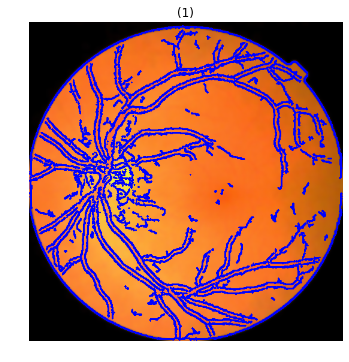

14345 points


In [15]:
def display_contours(image, contours, color = (255, 0, 0), thickness = -1, title = None):
    imShow = image.copy()
    for i in range(0, len(contours)):
        cv2.drawContours(imShow, contours, i, color, thickness)
    show_images([imShow], scale=0.7, titles=title)
    
image = ref_image

# this is a good threshold for Canny edge finder, but it does not always work. We will see how to deal with it furhter on.
thresh = 4
# Searcing for the eye
# Let's see how this works setp-by-step
# convert to a one channel image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Canny edge finder
edges = np.array([])
edges = cv2.Canny(gray, thresh, thresh * 3, edges)

# Find contours
# second output is hierarchy - we are not interested in it.
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Let's see what we've got:
display_contours(image, contours, thickness=2)
print "{:d} points".format(len(np.vstack(np.array(contours))))

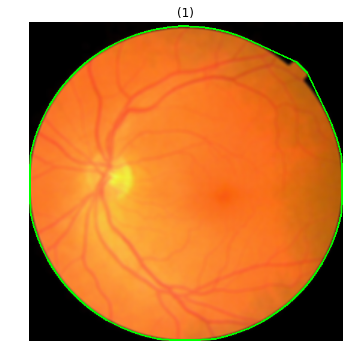

In [16]:
# Now let's get only what we need out of it
hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
hull = np.vstack(hull_contours)

# we only get one contour out of it, let's see it
display_contours(image, [hull], thickness=2, color=(0, 255, 0))

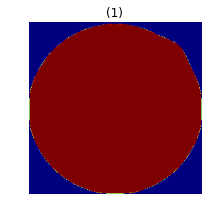

In [17]:
# Now let's create a mask for this image and later resize it to 256x256. It will be handy in the future
def createMask((rows, cols), hull):
    # black image
    mask = np.zeros((rows, cols), dtype=np.uint8)
    # blit our contours onto it in white color
    cv2.drawContours(mask, [hull], 0, 255, -1)
    return mask

mask = createMask(image.shape[0:2], hull)
mask = cv2.resize(mask, (256, 256))

show_images([mask])

###Putting it all together:

In [18]:
def find_eye(image, thresh = 4, size=256):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Canny edge finder
    edges = np.array([])
    edges = cv2.Canny(gray, thresh, thresh * 3, edges)

    # Find contours
    # second output is hierarchy - we are not interested in it.
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Now let's get only what we need out of it
    hull_contours = cv2.convexHull(np.vstack(np.array(contours)))
    hull = np.vstack(hull_contours)
    
    def createMask((rows, cols), hull):
        # black image
        mask = np.zeros((rows, cols), dtype=np.uint8)
        # blit our contours onto it in white color
        cv2.drawContours(mask, [hull], 0, 255, -1)
        return mask

    mask = createMask(image.shape[0:2], hull)
    
    # returning the hull to illustrate a few issues below
    return mask, hull

##Histogram Specification
####For all 3 channels of each image:
1. Create histograms: reference image, input image
2. Create CDFs:
CDF is defined as $H_i= {N \over |I|} \sum\limits_{j=0}^{i}h_j$, where $h_j$ is the j-th bin of histogram $h$, $N$ is the maximum color value (255 in our case)
3. Map image to reference, i.e. for color $i$ in the input image, find color $j$ in the output: $\DeclareMathOperator*{\argmin}{\arg\!\min} j = \argmin_{k}{|H^{inp}_i - H^{ref}_k|}$

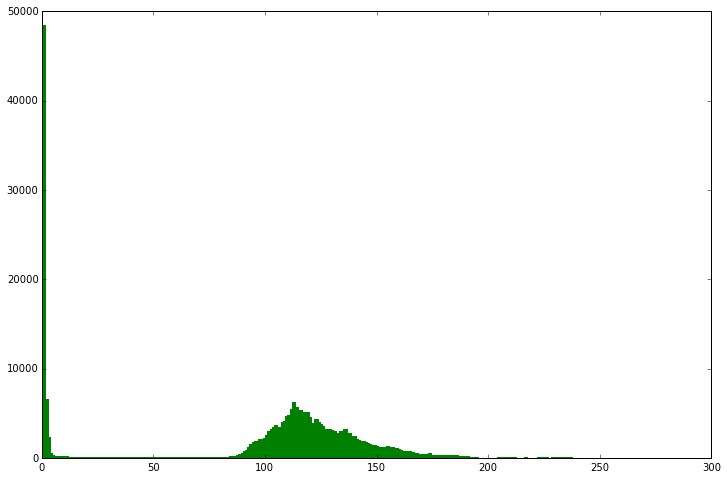

In [19]:
# here is the histogram of the reference image:
hist_green = cv2.calcHist([ref_image], [1], None, [256], np.array([0, 255]))
fig = plt.figure()
plt.bar(np.arange(256), hist_green, width=2, color='g', edgecolor='none')
fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * 2)
plt.show()


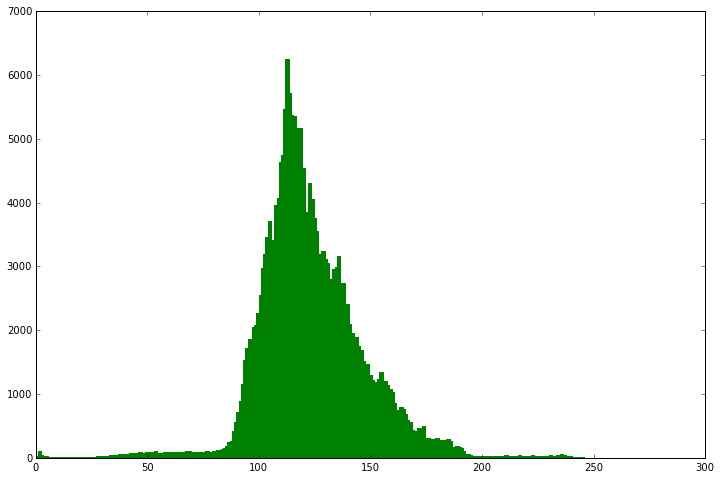

In [20]:
# we should really take it over the masked region, to remove the irrelevent background
mask, hull = find_eye(ref_image)
hist_green = cv2.calcHist([ref_image], [1], mask, [256], np.array([0, 255]))
fig = plt.figure()
plt.bar(np.arange(256), hist_green, width=2, color='g', edgecolor='none')
fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * 2)
plt.show()


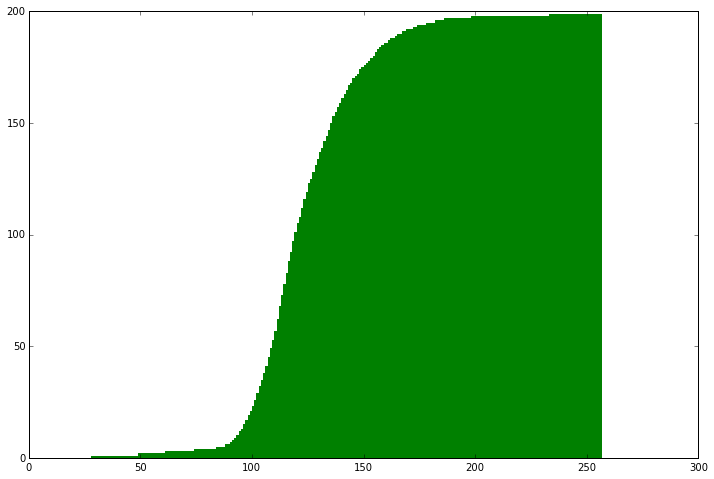

In [21]:
old_images = images
images = [ref_image]

def saturate (v):
    return map(lambda a: min(max(round(a), 0), 255), v)
    
maskHull = map(lambda i: find_eye(i)[0], images)
channels = map(lambda i: cv2.split(i), images)
imMask = zip(channels, maskHull)

# grab three histograms - one for each channel
histPerChannel = map(lambda (c, mask): \
                     [cv2.calcHist([cimage], [0], mask,  [256], np.array([0, 255])) for cimage in c], imMask)
# compute the cdf's. 
# they are normalized & saturated: values over 255 are cut off.
cdfPerChannel = map(lambda (hChan, im): \
                    [saturate(np.cumsum(h) * 255.0 / (im.shape[0] * im.shape[1])) for h in hChan], zip(histPerChannel, images))

# let's see the cdf over the green channel
fig = plt.figure()
plt.bar(np.arange(256), cdfPerChannel[0][1], width=2, color='g', edgecolor='none')
fig.set_size_inches(np.array(fig.get_size_inches(), dtype=np.float) * 2)
plt.show()


In [22]:
# now compute the map. We will need the reference image cdf for that, so we might as well put it all together:
def saturate (v):
    return np.array(map(lambda a: min(max(round(a), 0), 255), v))

def calc_hist(images):
    maskHull = map(lambda i: find_eye(i)[0], images)
    channels = map(lambda i: cv2.split(i), images)
    imMask = zip(channels, maskHull)

    # grab three histograms - one for each channel
    histPerChannel = map(lambda (c, mask): \
                         [cv2.calcHist([cimage], [0], mask,  [256], np.array([0, 255])) for cimage in c], imMask)
    # compute the cdf's. 
    # they are normalized & saturated: values over 255 are cut off.
    cdfPerChannel = map(lambda (hChan, im): \
                        [saturate(np.cumsum(h) * 255.0 / (im.shape[0] * im.shape[1])) for h in hChan], zip(histPerChannel, images))
    
    return np.array(cdfPerChannel)

# compute color map based on minimal distances beteen cdf values of ref and input images    
def getMin (ref, img):
    l = [np.argmin(np.abs(ref - i)) for i in img]
    return np.array(l)

# compute and apply color map on all channels of the image
def map_image(image, refHist, imageHist):
    # each of the arguments contains histograms over 3 channels
    mp = np.array([getMin(r, i) for (r, i) in zip(refHist, imageHist)])

    channels = np.array(cv2.split(image))
    mappedChannels = np.array([mp[i][channels[i].reshape(-1)].reshape(image.shape[0:2]) for i in range(0, 3)])
                                
    return cv2.merge(mappedChannels).astype(np.uint8)

# compute the histograms on all three channels for all images
def histogram_specification(ref, images):
        cdfs = calc_hist(images)
        mapped = [map_image(images[i], ref[0], cdfs[i, :, :]) for i in range(len(images))]
        return mapped

Reference Image


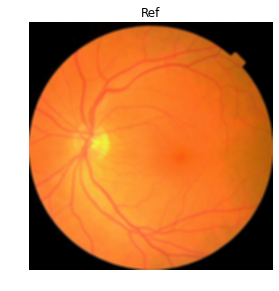

Original Images


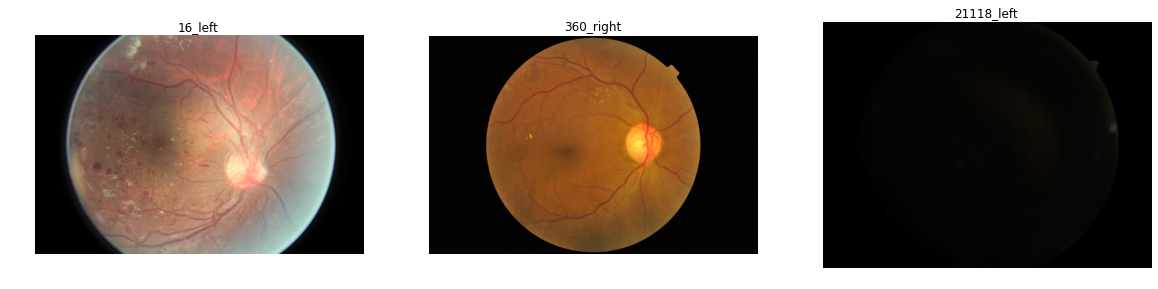

Mapped Images


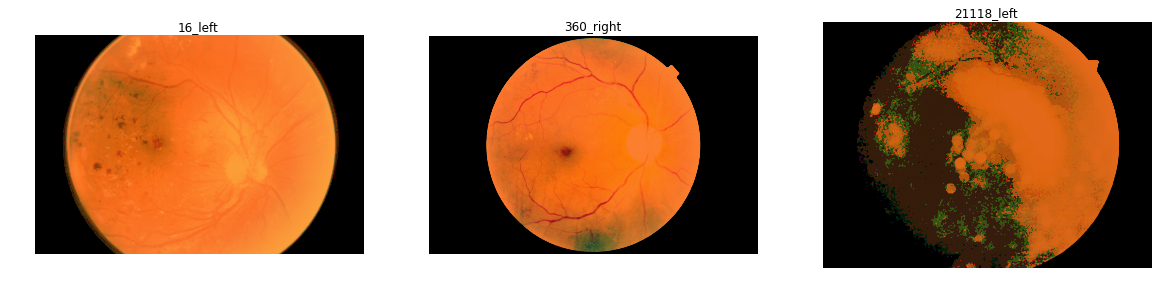

In [23]:
# the fruit of our labor
images = old_images
refHist = calc_hist([ref_image])
histSpec = histogram_specification(refHist, images)

print "Reference Image"
show_images([ref_image], ["Ref"], scale = 0.9)
print "Original Images"
show_images(images, titles = image_titles, scale = 0.9)
print "Mapped Images"
show_images(histSpec, titles = image_titles, scale = 0.9)